# Paulius Minajevas 2110599 classes["airplane", "pizza", "sheep"]

## Setup

In [30]:
!pip install fiftyone
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.3 MB/s eta 0:00:00


In [31]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

import torch
import torch.nn as nn

import torchvision
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics.functional import multiclass_f1_score

import os
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import random
import math

import numpy as np
import pandas as pd

from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb
from glob import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [80]:
classes=["airplane", "pizza", "sheep"]
default_dir = r"coco-2017"
train_dir = "train"
test_dir = "test"
model_path = "drive/MyDrive/Colab Notebooks/models/UNetPM_test.pt"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [61]:
from google.colab import drive
drive.mount('/content/drive')

def save_model(model, path):
  torch.save(model.state_dict(), path)

def load_model(model, path):
  model.load_state_dict(torch.load(path, map_location=torch.device(device)))
  return model

Mounted at /content/drive


## Configure data

Training/testing split ~80/20 (1104/200)

In [ ]:
train_dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["segmentations"],
    classes=classes,
    max_samples = 3000
)

test_dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations"],
    classes=classes,
    max_samples = 200
)

Generate masks for training and testing data

In [ ]:
is_airplane = F("label") == classes[0]
is_pizza = F("label") == classes[1]
is_sheep = F("label") == classes[2]

train_dataset.filter_labels("ground_truth", is_airplane).export(
    export_dir=f"{train_dir}/{classes[0]}",
    dataset_type=fo.types.ImageSegmentationDirectory,
    label_field="ground_truth"
)

train_dataset.filter_labels("ground_truth", is_pizza).export(
    export_dir=f"{train_dir}/{classes[1]}",
    dataset_type=fo.types.ImageSegmentationDirectory,
    label_field="ground_truth"
)

train_dataset.filter_labels("ground_truth", is_sheep).export(
    export_dir=f"{train_dir}/{classes[2]}",
    dataset_type=fo.types.ImageSegmentationDirectory,
    label_field="ground_truth"
)

test_dataset.filter_labels("ground_truth", is_airplane).export(
    export_dir=f"{test_dir}/{classes[0]}",
    dataset_type=fo.types.ImageSegmentationDirectory,
    label_field="ground_truth"
)

test_dataset.filter_labels("ground_truth", is_pizza).export(
    export_dir=f"{test_dir}/{classes[1]}",
    dataset_type=fo.types.ImageSegmentationDirectory,
    label_field="ground_truth"
)

test_dataset.filter_labels("ground_truth", is_sheep).export(
    export_dir=f"{test_dir}/{classes[2]}",
    dataset_type=fo.types.ImageSegmentationDirectory,
    label_field="ground_truth"
)

Clean up training images that have small percentages of pixels that stand for class compared to rest of image

In [52]:
allowed_ratio = 0.20

def calculate_mask_ratio(mask_path):
    mask_image = Image.open(mask_path)
    mask = transforms.functional.to_tensor(mask_image)
    mask[mask > 0] = 1
    class_pixel_count = (mask != 0).sum().item()
    total_pixel_count = mask.size()[1] * mask.size()[2]
    return class_pixel_count/total_pixel_count

def remove_invalid_images():
    for class_label in classes:
        count = 0
        removed = 0
        for file in os.listdir(os.path.join(train_dir, class_label, 'labels')):
            count+=1
            file_name = Path(file).stem
            mask_path = os.path.join(train_dir, class_label, 'labels', file_name) + '.png'
            image_path = os.path.join(train_dir, class_label, 'data', file_name) + '.jpg'

            ratio = calculate_mask_ratio(mask_path)

            if ratio < allowed_ratio:
                removed+=1
                os.remove(mask_path)
                os.remove(image_path)

        print(f"{class_label}: before - {count}; removed - {removed}; after - {count - removed}")

remove_invalid_images()

airplane: before - 1143; removed - 910; after - 233
pizza: before - 1287; removed - 572; after - 715
sheep: before - 573; removed - 417; after - 156


## Dataset

Create dataset with transformations included

Training uses crop to get more random images, while testing only resizes them to not change the picture itself
Training transformation also flips randomly the picture and its mask

Mask provided by dataset is encoded matrix with each pixel value as corresponding class index

In [64]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, training = False):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))

        self.images = []
        self.masks = []
        self.classLabel = []
        self.training = training

        for i, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for image_name in os.listdir(os.path.join(class_path, "data")):
                if os.path.isdir(os.path.join(class_path, image_name)):
                    continue
                file_name = Path(image_name).stem
                self.images.append(os.path.join(class_path, 'data', file_name) + '.jpg')
                self.masks.append(os.path.join(class_path, 'labels', file_name) + '.png')
                self.classLabel.append(class_name)

    def transform(self, img, mask, classLabel):
        pad_x = math.ceil(max(0, 256 - img.width)/ 2)
        pad_y = math.ceil(max(0, 256 - img.height)/ 2)
        img = transforms.functional.pad(img, [pad_x, pad_y])
        mask = transforms.functional.pad(mask, [pad_x, pad_y])

        if (self.training):
            crop_parm = transforms.RandomCrop.get_params(img, output_size = (256, 256))
            img = transforms.functional.crop(img, *crop_parm)
            mask = transforms.functional.crop(mask, *crop_parm)

            if (random.random() > 0.5):
                img = transforms.functional.hflip(img)
                mask = transforms.functional.hflip(mask)
        else:
            img = transforms.functional.resize(img, (256, 256))
            mask = transforms.functional.resize(mask, (256, 256))

        img = transforms.functional.to_tensor(img)
        img = transforms.functional.normalize(img, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        mask = transforms.functional.to_tensor(mask)

        mask[mask > 0] = classes.index(classLabel) + 1

        return img, mask

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        return self.transform(image.convert('RGB'), mask, self.classLabel[idx])

In [65]:
num_workers = 2
batch_size = 25

train_dataset = CustomDataset('./train', True)
test_dataset = CustomDataset('./test', False)

train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

## Fully Convolutional Network (U-Net architecture)

In [66]:
class UNetPM(torch.nn.Module):
    def __init__(self, in_channels, out_classes):
        super().__init__()
        self.num_classes = out_classes

        self.conv1_1  = torch.nn.Conv2d(in_channels, 16, (3, 3), padding = 'same')
        self.relu1_1  = torch.nn.ReLU()
        self.conv1_2  = torch.nn.Conv2d(16, 16, (3, 3), padding = 'same')
        self.relu1_2  = torch.nn.ReLU()

        self.pool2    = torch.nn.MaxPool2d((2, 2), (2, 2))
        self.conv2_1  = torch.nn.Conv2d(16, 32, (3, 3), padding = 'same')
        self.relu2_1  = torch.nn.ReLU()
        self.conv2_2  = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
        self.relu2_2  = torch.nn.ReLU()

        self.pool3    = torch.nn.MaxPool2d((2, 2), (2, 2))
        self.conv3_1  = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
        self.relu3_1  = torch.nn.ReLU()
        self.conv3_2  = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
        self.relu3_2  = torch.nn.ReLU()

        self.pool4    = torch.nn.MaxPool2d((2, 2), (2, 2))
        self.conv4_1  = torch.nn.Conv2d(64, 128, (3, 3), padding = 'same')
        self.relu4_1  = torch.nn.ReLU()
        self.conv4_2  = torch.nn.Conv2d(128, 128, (3, 3), padding = 'same')
        self.relu4_2  = torch.nn.ReLU()

        self.upconv5  = torch.nn.ConvTranspose2d(128, 64, (2,2), (2,2))
        self.conv5_1  = torch.nn.Conv2d(128, 128, (3, 3), padding = 'same')
        self.relu5_1  = torch.nn.ReLU()
        self.conv5_2  = torch.nn.Conv2d(128, 64, (3, 3), padding = 'same')
        self.relu5_2  = torch.nn.ReLU()

        self.upconv6  = torch.nn.ConvTranspose2d(64, 32, (2,2), (2,2))
        self.conv6_1  = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
        self.relu6_1  = torch.nn.ReLU()
        self.conv6_2  = torch.nn.Conv2d(64, 32, (3, 3), padding = 'same')
        self.relu6_2  = torch.nn.ReLU()

        self.upconv7  = torch.nn.ConvTranspose2d(32, 16, (2,2), (2,2))
        self.conv7_1  = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
        self.relu7_1  = torch.nn.ReLU()
        self.conv7_2  = torch.nn.Conv2d(32, 16, (3, 3), padding = 'same')
        self.relu7_2  = torch.nn.ReLU()

        self.conv8    = torch.nn.Conv2d(16, out_classes, (1, 1))

    def forward(self, x):
        block1 = torch.nn.Sequential(self.conv1_1,self.relu1_1,self.conv1_2,self.relu1_2)(x)
        block2 = torch.nn.Sequential(self.pool2,self.conv2_1,self.relu2_1,self.conv2_2,self.relu2_2)(block1)
        block3 = torch.nn.Sequential(self.pool3,self.conv3_1,self.relu3_1,self.conv3_2,self.relu3_2)(block2)
        block4 = torch.nn.Sequential(self.pool4,self.conv4_1,self.relu4_1,self.conv4_2,self.relu4_2)(block3)

        block4_5 = torch.cat([self.upconv5(block4), block3], dim = 1)

        block5 = torch.nn.Sequential(self.conv5_1,self.relu5_1,self.conv5_2,self.relu5_2)(block4_5)

        block5_6 = torch.cat([self.upconv6(block5), block2], dim = 1)

        block6 = torch.nn.Sequential(self.conv6_1,self.relu6_1,self.conv6_2,self.relu6_2)(block5_6)
        block6_7 = torch.cat([self.upconv7(block6), block1], dim = 1)

        block7 = torch.nn.Sequential(self.conv7_1,self.relu7_1,self.conv7_2,self.relu7_2)(block6_7)
        block8 = torch.nn.Sequential(self.conv8)(block7)

        return block8

## Train and evaluate

Model outputs logit values but because of integrated softmax in CrossEntropy loss it is not needed to use softmax before passing predictions to loss function

Truths are passed to loss function as an encoded matrix provided by datasource

In [67]:
def train_epoch(optimizer, loss_func, model, loader):
    classes = model.num_classes
    model.train()
    loss_acum = np.array([], dtype = np.float32)

    for images, masks in loader:
      optimizer.zero_grad()

      images = images.to(device)
      masks = masks.squeeze(1).long().to(device)

      pred = model(images)
      loss = loss_func(pred, masks)
      loss_acum = np.append(loss_acum, loss.cpu().detach().numpy())

      loss.backward()
      optimizer.step()

    return np.mean(loss_acum)

Model outputs are passed through softmax to become possibilities that sum up to 1 and afterwards argmax is used to get highest possibility index of output channel which stands for different class index (background and three training classes)

In [68]:
def evaluate(model, loader):
  model.eval()

  total_iou = 0.0
  total_predictions = 0

  for images, masks in loader:
    images = images.to(device)
    masks = masks.numpy()

    with torch.no_grad():
      pred = model(images)

    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    pred = pred.cpu().detach().numpy()

    intersection = 0.0
    union = 0.0
    for i in range(len(masks)):
      mask_class = masks[i].max()
      intersection += ((pred[i] == masks[i]) & (mask_class == pred[i])).sum()
      union += ((mask_class == masks[i]) | (mask_class == pred[i])).sum()

    iou = 0.0
    if (union != 0):
      iou = intersection / union

    total_iou += iou
    total_predictions += 1

  avg_iou = total_iou / total_predictions
  return avg_iou

Saving model checkpoints that have IoU higher than 50 and is new highest

In [72]:
def train_and_eval(model, loader_train, loader_valid, epoch_count, lr):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  start_time = datetime.now()
  current_best = 0.5

  train_iou_acum = []
  valid_iou_acum = []
  for epoch in range(epoch_count):
    loss = train_epoch(optimizer, loss_func, model, loader_train)

    train_iou = evaluate(model, loader_train)
    train_iou_acum.append(train_iou)
    valid_iou = evaluate(model, loader_valid)
    valid_iou_acum.append(valid_iou)

    if (valid_iou > current_best):
        current_best = valid_iou
        save_model(model, f"drive/MyDrive/Colab Notebooks/models/UNetPM_{valid_iou}.pt")
        break;

    elapsed = timedelta(seconds=((datetime.now() - start_time).total_seconds()))
    print(f'Epoch: {epoch}, Time: {elapsed}, Training loss: {loss}')
    print(f'Training IoU: {np.round(train_iou * 100)}, Validation IoU: {np.round(valid_iou * 100)}')

  return train_iou_acum, valid_iou_acum

## Train new model

Parameter count: 627,348


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0, Time: 0:00:25.798989, Training loss: 1.153909683227539
Training IoU: 51.0, Validation IoU: 22.0
Epoch: 1, Time: 0:00:49.981366, Training loss: 0.9382761716842651
Training IoU: 50.0, Validation IoU: 22.0
Epoch: 2, Time: 0:01:16.081942, Training loss: 0.9209842085838318
Training IoU: 51.0, Validation IoU: 22.0
Epoch: 3, Time: 0:01:40.066290, Training loss: 0.9038172364234924
Training IoU: 54.0, Validation IoU: 22.0
Epoch: 4, Time: 0:02:05.835051, Training loss: 0.8926241397857666
Training IoU: 53.0, Validation IoU: 22.0
Epoch: 5, Time: 0:02:31.547678, Training loss: 0.8928970098495483
Training IoU: 52.0, Validation IoU: 23.0
Epoch: 6, Time: 0:02:55.258208, Training loss: 0.8812063336372375
Training IoU: 57.0, Validation IoU: 22.0
Epoch: 7, Time: 0:03:21.026647, Training loss: 0.890228271484375
Training IoU: 53.0, Validation IoU: 23.0
Epoch: 8, Time: 0:03:45.566599, Training loss: 0.8981190323829651
Training IoU: 54.0, Validation IoU: 23.0
Epoch: 9, Time: 0:04:10.634037, Trainin

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 89, Time: 0:37:33.389642, Training loss: 0.47128427028656006
Training IoU: 75.0, Validation IoU: 40.0
Epoch: 90, Time: 0:37:59.114652, Training loss: 0.44865015149116516
Training IoU: 76.0, Validation IoU: 45.0
Epoch: 91, Time: 0:38:24.419253, Training loss: 0.43908196687698364
Training IoU: 76.0, Validation IoU: 49.0
Epoch: 92, Time: 0:38:48.496271, Training loss: 0.45288413763046265
Training IoU: 77.0, Validation IoU: 45.0
Epoch: 93, Time: 0:39:14.122818, Training loss: 0.4466913938522339
Training IoU: 78.0, Validation IoU: 42.0
Epoch: 94, Time: 0:39:38.217903, Training loss: 0.44688403606414795
Training IoU: 75.0, Validation IoU: 44.0
Epoch: 95, Time: 0:40:04.004864, Training loss: 0.4433971047401428
Training IoU: 75.0, Validation IoU: 48.0
Epoch: 96, Time: 0:40:29.667770, Training loss: 0.44301486015319824
Training IoU: 77.0, Validation IoU: 43.0
Epoch: 97, Time: 0:40:53.429904, Training loss: 0.4206794202327728
Training IoU: 78.0, Validation IoU: 44.0
Epoch: 98, Time: 0:41:

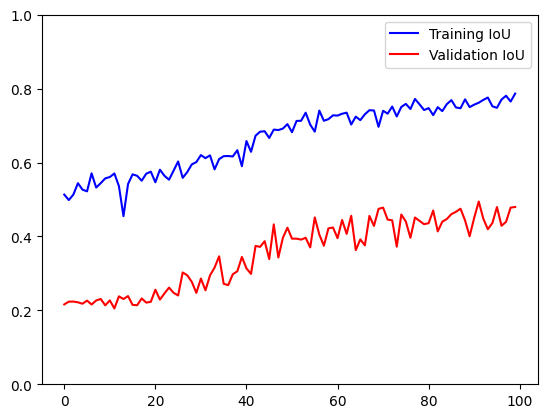

In [74]:
model = UNetPM(3, 4).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
train_iou, valid_iou = train_and_eval(model, train_loader, test_loader, epoch_count = 100, lr = 0.001)

plt.clf()
plt.plot(train_iou, 'b', label = 'Training IoU')
plt.plot(valid_iou, 'r', label = 'Validation IoU')
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()

## Load model

In [ ]:
model = UNetPM(3, 4).to(device)
model = load_model(model, model_path)

In [71]:
save_model(model, f"drive/MyDrive/Colab Notebooks/models/UNetPM_test.pt")

## Metrics

In [32]:
def calc_metrics(model, loader):
  model.eval()

  total_dice = 0.0
  total_images = 0

  test_pred = []
  test_masks = []

  for images, masks in loader:
    images = images.to(device)
    masks = masks.numpy()

    with torch.no_grad():
      pred = model(images)

    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    pred = pred.cpu().detach().numpy()

    for i in range(len(masks)):
      mask_class = masks[i].max()
      intersection = ((pred[i] == masks[i]) & (mask_class == pred[i])).sum()
      total_dice += 2 * intersection / (pred[i].size + masks[i].size)
      total_images += 1
      test_pred.append(pred[i].flatten())
      test_masks.append(masks[i].flatten())

  test_pred = np.concatenate(test_pred)
  test_masks = np.concatenate(test_masks)

  micro_f1 = float(multiclass_f1_score(torch.Tensor(test_pred).long(), torch.Tensor(test_masks).long(), num_classes=4, average="micro"))
  macro_f1 = float(multiclass_f1_score(torch.Tensor(test_pred).long(), torch.Tensor(test_masks).long(), num_classes=4, average="macro"))

  return total_dice/total_images, micro_f1, macro_f1

In [35]:
dice, micro_f1, macro_f1 = calc_metrics(model, test_loader)
print(f"Dice: {dice}, Micro-F1: {micro_f1}, Macro-F1: {macro_f1}")

Dice: 0.15362777709960937, Micro-F1: 0.8323683738708496, Macro-F1: 0.6329094171524048


## UI and REST API

In [75]:
!pip install Flask==3.0.0 pyngrok==7.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
ERROR: Cannot uninstall 'blinker'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [101]:
from google.colab import userdata
from pyngrok import ngrok
from flask import Flask, render_template, request, jsonify
from PIL import Image
from io import BytesIO

ngrok_key = userdata.get('ngrok_auth_key')
port = 5000

ngrok.set_auth_token(ngrok_key)
ngrok.connect(port).public_url

'https://0227-34-125-110-6.ngrok-free.app'

In [103]:
def img_transforms(img):
    pad_x = math.ceil(max(0, 256 - img.width)/ 2)
    pad_y = math.ceil(max(0, 256 - img.height)/ 2)
    img = transforms.functional.pad(img, [pad_x, pad_y])
    img = transforms.functional.resize(img, (256, 256))

    return img

def show_mask(mask):
    plt.clf()
    cmap = plt.cm.get_cmap('Set1', 4)

    colorMask = cmap(mask.squeeze())
    _, ax = plt.subplots()

    cbar = plt.colorbar(ax.imshow(colorMask, cmap=cmap, vmin=0, vmax=3), ax=ax, ticks=np.arange(0, 4))
    cbar.set_label('Class')

    plt.show()

def predict_picture(img, model):
    img = transforms.functional.to_tensor(img_transforms(img)).unsqueeze(0).to('cpu')

    model.eval()
    with torch.no_grad():
      pred = model(img)

    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)

    show_mask(pred)
    totalPixels = pred.numpy().size

    return f'background - {round((pred==0).sum().item()/totalPixels, 2)*100}%, {classes[0]} - {round((pred==1).sum().item()/totalPixels, 2)*100}%, {classes[1]} - {round((pred==2).sum().item()/totalPixels, 2)*100}%, {classes[2]} - {round((pred==3).sum().item()/totalPixels, 2)*100}%'

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [30/Apr/2024 19:26:55] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Apr/2024 19:26:55] "GET /favicon.ico HTTP/1.1" 404 -
<ipython-input-102-27d009ed418a>:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  file_bytes = np.fromstring(image_data, np.uint8)


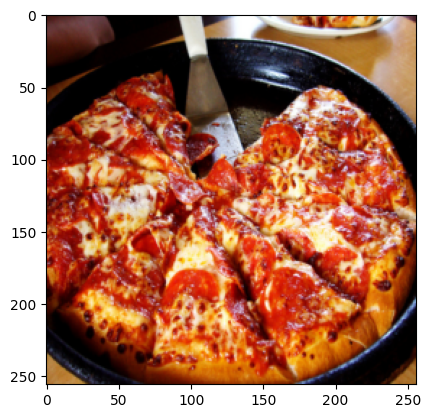

<ipython-input-99-4a6f7ec0f430>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', 4)


<Figure size 640x480 with 0 Axes>

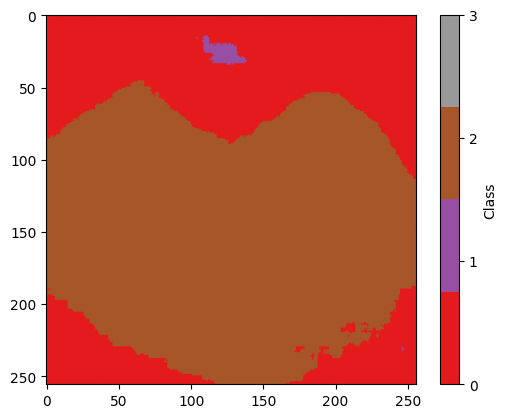

INFO:werkzeug:127.0.0.1 - - [30/Apr/2024 19:27:00] "POST / HTTP/1.1" 200 -


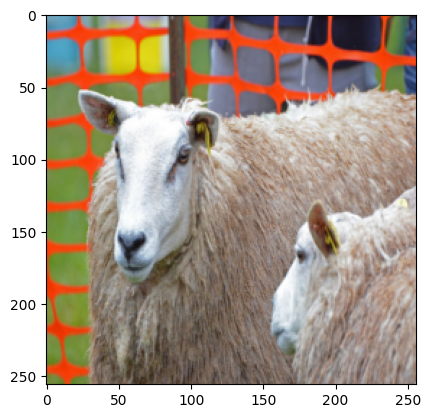

<Figure size 640x480 with 0 Axes>

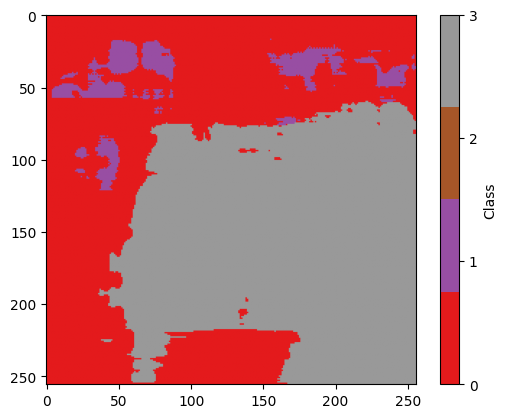

INFO:werkzeug:127.0.0.1 - - [30/Apr/2024 19:27:26] "POST / HTTP/1.1" 200 -


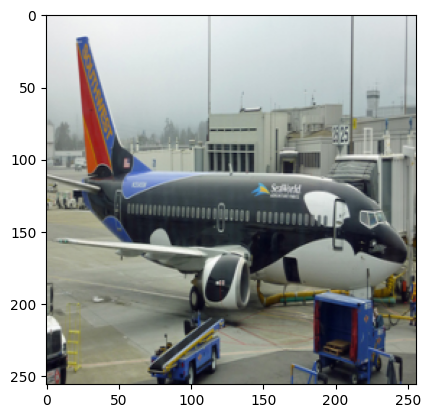

<Figure size 640x480 with 0 Axes>

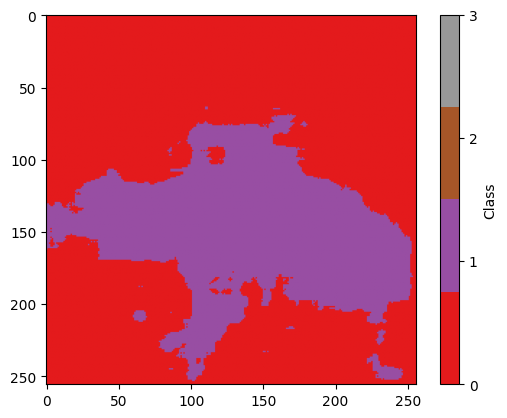

INFO:werkzeug:127.0.0.1 - - [30/Apr/2024 19:27:47] "POST / HTTP/1.1" 200 -


In [102]:
from flask import Flask, render_template, request, jsonify
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

app = Flask(__name__, template_folder='./')

@app.route('/')
def home():
  return render_template('index.html')

@app.route('/', methods=['POST'])
def predict_image():
    model = UNetPM(3, 4).to('cpu')
    model = load_model(model, model_path)

    image_data = request.files['image'].read()

    file_bytes = np.fromstring(image_data, np.uint8)
    file_jpgdata = BytesIO(file_bytes)

    pilImage = Image.open(file_jpgdata)
    plt.imshow(img_transforms(pilImage))
    plt.show()

    return jsonify({"message": f"Picture's contents: {predict_picture(pilImage, model)}"})


app.run()